In [1]:
!pip install pandas matplotlib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Performance Analysis - Distributed Computing Benchmarks

This notebook analyzes performance metrics from distributed computing benchmarks across three scaling scenarios:
- **Strong Scaling (SS)**: Fixed problem size with increasing resources
- **Weak Scaling (WS)**: Problem size scales proportionally with resources
- **Worker Sweep (W-)**: Analysis across different worker configurations

## 1. Load and Categorize Data

In [3]:
# Load and categorize CSV files
LOG_DIR = "/home/intel/ritik/iisc/deas-project/logs-prod/6767P/4-cores-per-worker"

csv_files = glob.glob(os.path.join(LOG_DIR, "*.csv"))

strong_scaling_files = [f for f in csv_files if os.path.basename(f).startswith('SS')]
weak_scaling_files = [f for f in csv_files if os.path.basename(f).startswith('WS')]
worker_sweep_files = [f for f in csv_files if os.path.basename(f).startswith('W-')]

def read_and_combine(file_list):
    if not file_list:
        return pd.DataFrame()
    dfs = [pd.read_csv(f) for f in file_list]
    return pd.concat(dfs, ignore_index=True)

df_strong_scaling = read_and_combine(strong_scaling_files)
df_weak_scaling = read_and_combine(weak_scaling_files)
df_worker_sweep = read_and_combine(worker_sweep_files)

print(f"Loaded - Strong Scaling: {len(df_strong_scaling)}, Weak Scaling: {len(df_weak_scaling)}, Worker Sweep: {len(df_worker_sweep)}")

Loaded - Strong Scaling: 5, Weak Scaling: 5, Worker Sweep: 5


In [4]:
# Calculate stage metrics
def calculate_stage_metrics(df):
    df = df.copy()
    
    stage_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_time')]
    stage_throughput_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_throughput')]
    executor_run_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_executorRunTime')]
    executor_cpu_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_executorCpuTime')]
    jvm_gc_time_cols = [col for col in df.columns if col.startswith('stage') and col.endswith('_jvmGCTime')]
    
    df['total_stage_time'] = df[stage_time_cols].sum(axis=1)
    df['average_stage_throughput'] = df[stage_throughput_cols].mean(axis=1)
    df['Total_Executor_Run_Time'] = df[executor_run_time_cols].sum(axis=1)
    df['Total_Executor_CPU_Time'] = df[executor_cpu_time_cols].sum(axis=1)
    df['Total_JVM_GC_Time'] = df[jvm_gc_time_cols].sum(axis=1)
    
    return df

df_strong_scaling = calculate_stage_metrics(df_strong_scaling)
df_weak_scaling = calculate_stage_metrics(df_weak_scaling)
df_worker_sweep = calculate_stage_metrics(df_worker_sweep)

print("Metrics calculated")

Metrics calculated


## 2. Strong Scaling Analysis - Amdahl's Law

Analyzing how the system performs with fixed problem size and increasing computing resources. Speedup is calculated as T1/Tn where T1 is the baseline execution time.

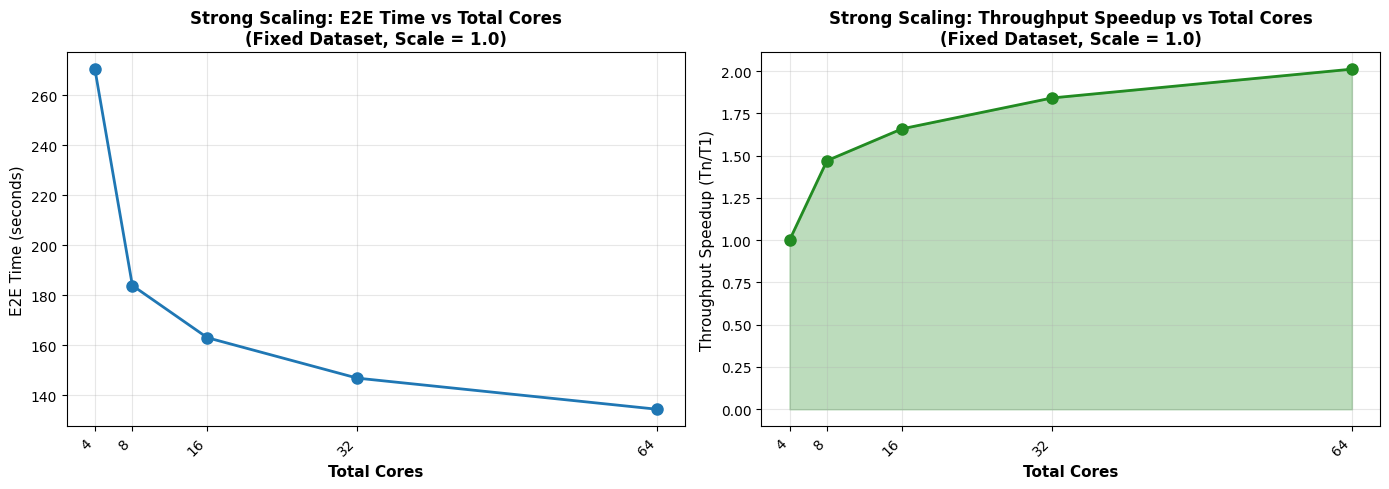

Strong Scaling Performance:
----------------------------------------------------------------------------------------------------
1W-4C      | Cores:   4 | Throughput:   2933.4 records/sec | Speedup: 1.00x
2W-4C      | Cores:   8 | Throughput:   4313.0 records/sec | Speedup: 1.47x
4W-4C      | Cores:  16 | Throughput:   4865.1 records/sec | Speedup: 1.66x
8W-4C      | Cores:  32 | Throughput:   5400.5 records/sec | Speedup: 1.84x
16W-4C     | Cores:  64 | Throughput:   5900.4 records/sec | Speedup: 2.01x


In [5]:
df_ss = df_strong_scaling.copy()

df_ss['config_name'] = (
    df_ss['num_workers'].astype(str) + 'W-' +
    df_ss['cores_per_worker'].astype(str) + 'C'
)

df_ss['total_cores'] = df_ss['num_workers'] * df_ss['cores_per_worker']
df_ss = df_ss.sort_values('total_cores')

throughput_1 = df_ss.iloc[0]['E2E_throughput']
df_ss['speedup'] = df_ss['E2E_throughput'] / throughput_1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(df_ss['total_cores'], df_ss['E2E_time'], marker='o', linewidth=2, markersize=8)
ax1.set_xticks(df_ss['total_cores'])
ax1.set_xticklabels(df_ss['total_cores'], rotation=45, ha='right')
ax1.set_xlabel('Total Cores', fontsize=11, fontweight='bold')
ax1.set_ylabel('E2E Time (seconds)', fontsize=11)
ax1.set_title('Strong Scaling: E2E Time vs Total Cores\n(Fixed Dataset, Scale = 1.0)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(df_ss['total_cores'], df_ss['speedup'], marker='o', linewidth=2, markersize=8, color='forestgreen')
ax2.fill_between(df_ss['total_cores'], df_ss['speedup'], alpha=0.3, color='forestgreen')
ax2.set_xticks(df_ss['total_cores'])
ax2.set_xticklabels(df_ss['total_cores'], rotation=45, ha='right')
ax2.set_xlabel('Total Cores', fontsize=11, fontweight='bold')
ax2.set_ylabel('Throughput Speedup (Tn/T1)', fontsize=11)
ax2.set_title('Strong Scaling: Throughput Speedup vs Total Cores\n(Fixed Dataset, Scale = 1.0)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Strong Scaling Performance:")
print("-" * 100)
for _, row in df_ss.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Throughput: {row['E2E_throughput']:8.1f} records/sec | Speedup: {row['speedup']:.2f}x")

## 3. Strong Scaling - Executor time Analysis

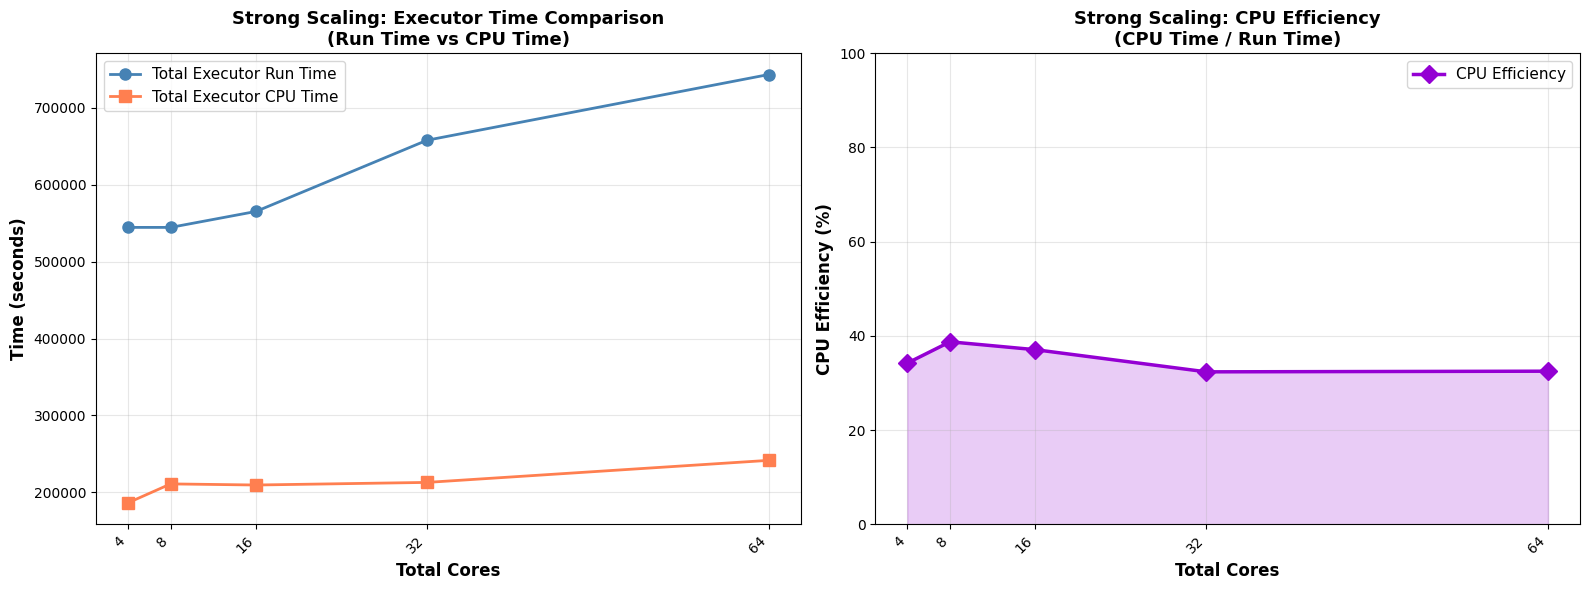


Strong Scaling - Executor Time Analysis:
Cores    Executor Run Time    Executor CPU Time    CPU Efficiency (%)  
----------------------------------------------------------------------------------------------------
4                 544593.00s          186269.00s              34.20%
8                 544582.00s          210922.00s              38.73%
16                565368.00s          209483.00s              37.05%
32                657928.00s          212865.00s              32.35%
64                743418.00s          241550.00s              32.49%


In [6]:
# Executor Time Analysis for Strong Scaling
df_ss_exec = df_strong_scaling.copy()

# Ensure we have the necessary columns
if 'total_cores' not in df_ss_exec.columns:
    df_ss_exec['total_cores'] = df_ss_exec['num_workers'] * df_ss_exec['cores_per_worker']

df_ss_exec = df_ss_exec.sort_values('total_cores')

# Calculate CPU Efficiency
df_ss_exec['CPU_Efficiency'] = (df_ss_exec['Total_Executor_CPU_Time'] / df_ss_exec['Total_Executor_Run_Time']) * 100

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graph 1: Total Executor Run Time and Total Executor CPU Time
ax1.plot(df_ss_exec['total_cores'], df_ss_exec['Total_Executor_Run_Time'], 
         marker='o', linewidth=2, markersize=8, label='Total Executor Run Time', color='steelblue')
ax1.plot(df_ss_exec['total_cores'], df_ss_exec['Total_Executor_CPU_Time'], 
         marker='s', linewidth=2, markersize=8, label='Total Executor CPU Time', color='coral')
ax1.set_xticks(df_ss_exec['total_cores'])
ax1.set_xticklabels(df_ss_exec['total_cores'], rotation=45, ha='right')
ax1.set_xlabel('Total Cores', fontsize=12, fontweight='bold')
ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Strong Scaling: Executor Time Comparison\n(Run Time vs CPU Time)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Graph 2: CPU Efficiency
ax2.plot(df_ss_exec['total_cores'], df_ss_exec['CPU_Efficiency'], 
         marker='D', linewidth=2.5, markersize=9, color='darkviolet', label='CPU Efficiency')
ax2.fill_between(df_ss_exec['total_cores'], df_ss_exec['CPU_Efficiency'], alpha=0.2, color='darkviolet')
ax2.set_xticks(df_ss_exec['total_cores'])
ax2.set_xticklabels(df_ss_exec['total_cores'], rotation=45, ha='right')
ax2.set_xlabel('Total Cores', fontsize=12, fontweight='bold')
ax2.set_ylabel('CPU Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Strong Scaling: CPU Efficiency\n(CPU Time / Run Time)', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nStrong Scaling - Executor Time Analysis:")
print("=" * 100)
print(f"{'Cores':<8} {'Executor Run Time':<20} {'Executor CPU Time':<20} {'CPU Efficiency (%)':<20}")
print("-" * 100)
for _, row in df_ss_exec.iterrows():
    print(f"{row['total_cores']:<8} {row['Total_Executor_Run_Time']:>18.2f}s {row['Total_Executor_CPU_Time']:>18.2f}s {row['CPU_Efficiency']:>18.2f}%")

## 4. Weak Scaling Analysis - Gustafson's Law

Analyzing how the system handles increasing problem sizes proportionally with computing resources. In weak scaling, both dataset scale and core count increase together.

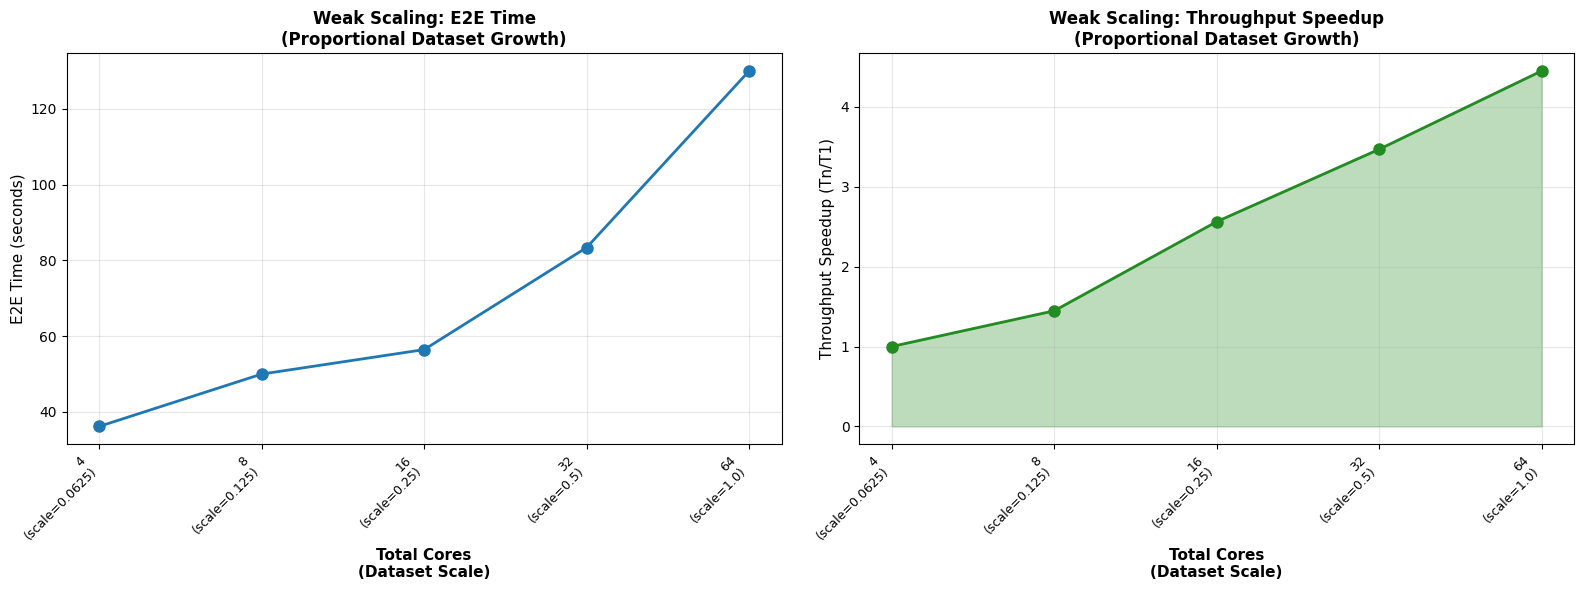

Weak Scaling Performance:
------------------------------------------------------------------------------------------------------------------------
1W-4C      | Cores:   4 | Scale:  0.1 | E2E Time:   36.16s | Throughput:   1370.5 records/sec | Speedup: 1.00x | CPU Eff: 65.03%
2W-4C      | Cores:   8 | Scale:  0.1 | E2E Time:   49.99s | Throughput:   1983.1 records/sec | Speedup: 1.45x | CPU Eff: 58.80%
4W-4C      | Cores:  16 | Scale:  0.2 | E2E Time:   56.45s | Throughput:   3512.1 records/sec | Speedup: 2.56x | CPU Eff: 57.04%
8W-4C      | Cores:  32 | Scale:  0.5 | E2E Time:   83.40s | Throughput:   4754.0 records/sec | Speedup: 3.47x | CPU Eff: 38.33%
16W-4C     | Cores:  64 | Scale:  1.0 | E2E Time:  130.04s | Throughput:   6098.4 records/sec | Speedup: 4.45x | CPU Eff: 31.86%


In [7]:
df_ws = df_weak_scaling.copy()

df_ws['config_name'] = (
    df_ws['num_workers'].astype(str) + 'W-' +
    df_ws['cores_per_worker'].astype(str) + 'C'
)

df_ws['total_cores'] = df_ws['num_workers'] * df_ws['cores_per_worker']
df_ws = df_ws.sort_values('total_cores')

df_ws['x_label'] = df_ws['total_cores'].astype(str) + '\n(scale=' + df_ws['dataset_scale'].astype(str) + ')'

throughput_1 = df_ws.iloc[0]['E2E_throughput']
df_ws['speedup'] = df_ws['E2E_throughput'] / throughput_1

# Calculate CPU Efficiency
df_ws['CPU_Efficiency'] = (df_ws['Total_Executor_CPU_Time'] / df_ws['Total_Executor_Run_Time']) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

x_positions = range(len(df_ws))

# Chart 1: E2E Time
ax1.plot(x_positions, df_ws['E2E_time'], marker='o', linewidth=2, markersize=8)
ax1.set_xticks(x_positions)
ax1.set_xticklabels(df_ws['x_label'], rotation=45, ha='right', fontsize=9)
ax1.set_xlabel('Total Cores\n(Dataset Scale)', fontsize=11, fontweight='bold')
ax1.set_ylabel('E2E Time (seconds)', fontsize=11)
ax1.set_title('Weak Scaling: E2E Time\n(Proportional Dataset Growth)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Chart 2: Throughput Speedup
ax2.plot(x_positions, df_ws['speedup'], marker='o', linewidth=2, markersize=8, color='forestgreen')
ax2.fill_between(x_positions, df_ws['speedup'], alpha=0.3, color='forestgreen')
ax2.set_xticks(x_positions)
ax2.set_xticklabels(df_ws['x_label'], rotation=45, ha='right', fontsize=9)
ax2.set_xlabel('Total Cores\n(Dataset Scale)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Throughput Speedup (Tn/T1)', fontsize=11)
ax2.set_title('Weak Scaling: Throughput Speedup\n(Proportional Dataset Growth)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Weak Scaling Performance:")
print("-" * 120)
for _, row in df_ws.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Scale: {row['dataset_scale']:4.1f} | "
          f"E2E Time: {row['E2E_time']:7.2f}s | Throughput: {row['E2E_throughput']:8.1f} records/sec | "
          f"Speedup: {row['speedup']:.2f}x | CPU Eff: {row['CPU_Efficiency']:.2f}%")

## 5. Stage Throughput Comparison: Strong vs Weak Scaling

Comparing average stage throughput between strong scaling (fixed dataset) and weak scaling (proportional dataset growth).

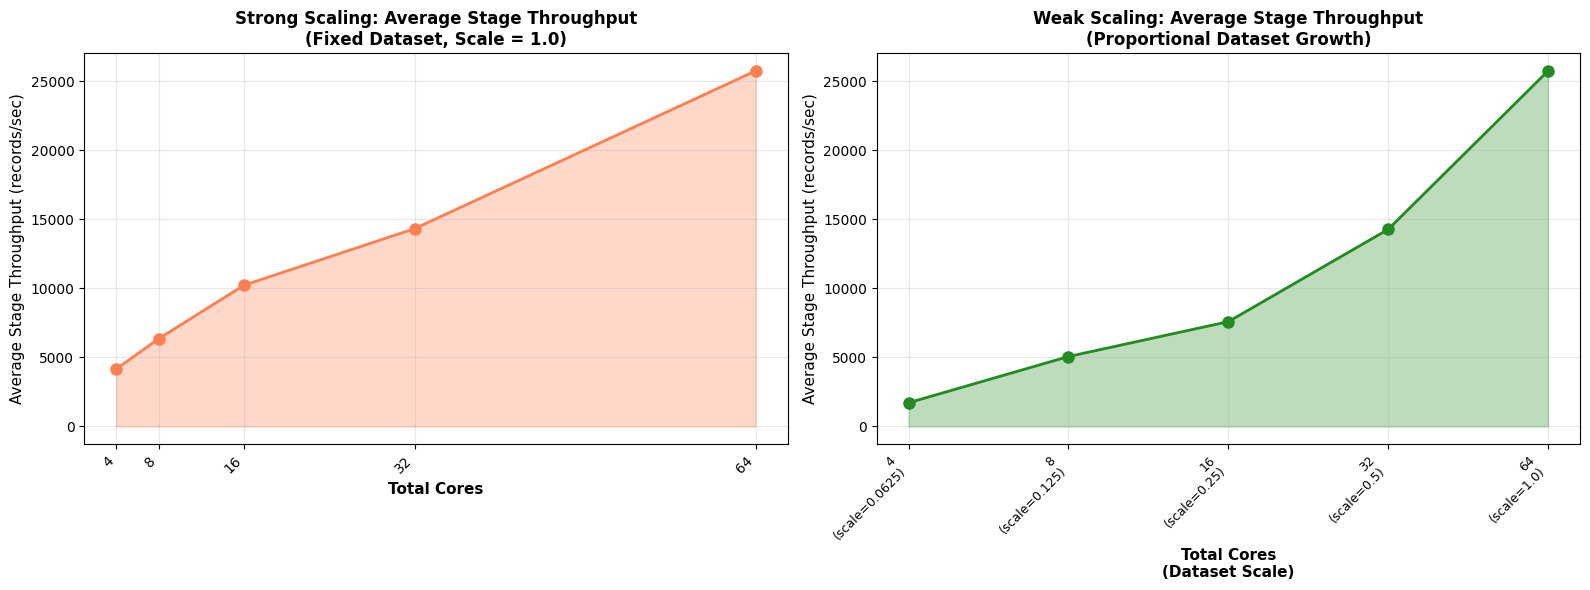


Stage Throughput Comparative Analysis:

Strong Scaling (Fixed Dataset):
------------------------------------------------------------------------------------------
1W-4C      | Cores:   4 | Avg Stage Throughput:   4154.7 records/sec
2W-4C      | Cores:   8 | Avg Stage Throughput:   6353.9 records/sec
4W-4C      | Cores:  16 | Avg Stage Throughput:  10227.8 records/sec
8W-4C      | Cores:  32 | Avg Stage Throughput:  14321.1 records/sec
16W-4C     | Cores:  64 | Avg Stage Throughput:  25746.5 records/sec

Weak Scaling (Proportional Dataset):
------------------------------------------------------------------------------------------
1W-4C      | Cores:   4 | Scale:  0.1 | Avg Stage Throughput:   1716.2 records/sec
2W-4C      | Cores:   8 | Scale:  0.1 | Avg Stage Throughput:   5064.1 records/sec
4W-4C      | Cores:  16 | Scale:  0.2 | Avg Stage Throughput:   7589.9 records/sec
8W-4C      | Cores:  32 | Scale:  0.5 | Avg Stage Throughput:  14276.6 records/sec
16W-4C     | Cores:  64 | Scal

In [8]:
# Combined visualization: Average Stage Throughput for Strong and Weak Scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Strong Scaling - Average Stage Throughput
ax1.plot(df_ss['total_cores'], df_ss['average_stage_throughput'], marker='o', linewidth=2, markersize=8, color='coral')
ax1.fill_between(df_ss['total_cores'], df_ss['average_stage_throughput'], alpha=0.3, color='coral')
ax1.set_xticks(df_ss['total_cores'])
ax1.set_xticklabels(df_ss['total_cores'], rotation=45, ha='right')
ax1.set_xlabel('Total Cores', fontsize=11, fontweight='bold')
ax1.set_ylabel('Average Stage Throughput (records/sec)', fontsize=11)
ax1.set_title('Strong Scaling: Average Stage Throughput\n(Fixed Dataset, Scale = 1.0)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Chart 2: Weak Scaling - Average Stage Throughput
x_positions_ws = range(len(df_ws))
ax2.plot(x_positions_ws, df_ws['average_stage_throughput'], marker='o', linewidth=2, markersize=8, color='forestgreen')
ax2.fill_between(x_positions_ws, df_ws['average_stage_throughput'], alpha=0.3, color='forestgreen')
ax2.set_xticks(x_positions_ws)
ax2.set_xticklabels(df_ws['x_label'], rotation=45, ha='right', fontsize=9)
ax2.set_xlabel('Total Cores\n(Dataset Scale)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Average Stage Throughput (records/sec)', fontsize=11)
ax2.set_title('Weak Scaling: Average Stage Throughput\n(Proportional Dataset Growth)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparative analysis
print("\nStage Throughput Comparative Analysis:")
print("=" * 90)
print("\nStrong Scaling (Fixed Dataset):")
print("-" * 90)
for _, row in df_ss.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Avg Stage Throughput: {row['average_stage_throughput']:8.1f} records/sec")

print("\nWeak Scaling (Proportional Dataset):")
print("-" * 90)
for _, row in df_ws.iterrows():
    print(f"{row['config_name']:10s} | Cores: {row['total_cores']:3d} | Scale: {row['dataset_scale']:4.1f} | Avg Stage Throughput: {row['average_stage_throughput']:8.1f} records/sec")

## 6. Worker Sweep Analysis

Analyzing the impact of different worker configurations while maintaining constant total compute resources (96 cores). This explores the trade-off between parallelism (number of workers) and per-worker resources (cores per worker).

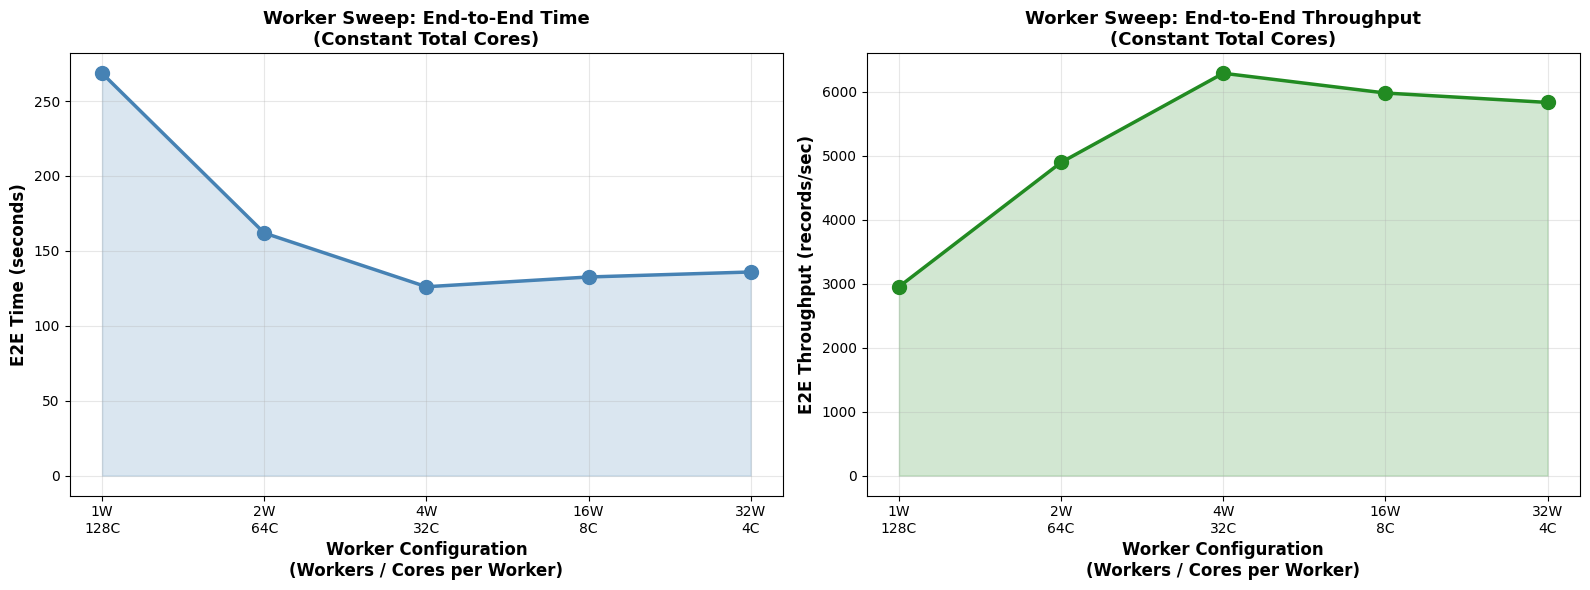

Worker Sweep Performance Analysis:
Config       Workers    Cores/W    Total Cores  E2E Time        E2E Throughput      
--------------------------------------------------------------------------------------------------------------
1W-128C      1          128        128                 268.53s             2953.2 rec/s
2W-64C       2          64         128                 161.92s             4897.5 rec/s
4W-32C       4          32         128                 126.04s             6291.5 rec/s
16W-8C       16         8          128                 132.56s             5982.4 rec/s
32W-4C       32         4          128                 135.90s             5835.3 rec/s


In [9]:
# Worker Sweep Analysis
df_worker = df_worker_sweep.copy()

# Create configuration labels
df_worker['config_name'] = (
    df_worker['num_workers'].astype(str) + 'W-' +
    df_worker['cores_per_worker'].astype(str) + 'C'
)

df_worker['total_cores'] = df_worker['num_workers'] * df_worker['cores_per_worker']
df_worker = df_worker.sort_values('num_workers')

# Create X-axis labels showing both workers and cores per worker
df_worker['x_label'] = (df_worker['num_workers'].astype(str) + 'W\n' +
                        df_worker['cores_per_worker'].astype(str) + 'C')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graph 1: E2E Time vs Total Cores
x_positions = range(len(df_worker))
ax1.plot(x_positions, df_worker['E2E_time'], marker='o', linewidth=2.5, markersize=10, color='steelblue')
ax1.fill_between(x_positions, df_worker['E2E_time'], alpha=0.2, color='steelblue')

ax1.set_xticks(x_positions)
ax1.set_xticklabels(df_worker['x_label'], rotation=0, ha='center', fontsize=10)
ax1.set_xlabel('Worker Configuration\n(Workers / Cores per Worker)', fontsize=12, fontweight='bold')
ax1.set_ylabel('E2E Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Worker Sweep: End-to-End Time\n(Constant Total Cores)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Graph 2: E2E Throughput vs Worker Configuration
ax2.plot(x_positions, df_worker['E2E_throughput'], marker='o', linewidth=2.5, markersize=10, color='forestgreen')
ax2.fill_between(x_positions, df_worker['E2E_throughput'], alpha=0.2, color='forestgreen')

ax2.set_xticks(x_positions)
ax2.set_xticklabels(df_worker['x_label'], rotation=0, ha='center', fontsize=10)
ax2.set_xlabel('Worker Configuration\n(Workers / Cores per Worker)', fontsize=12, fontweight='bold')
ax2.set_ylabel('E2E Throughput (records/sec)', fontsize=12, fontweight='bold')
ax2.set_title('Worker Sweep: End-to-End Throughput\n(Constant Total Cores)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed analysis
print("Worker Sweep Performance Analysis:")
print("=" * 110)
print(f"{'Config':<12} {'Workers':<10} {'Cores/W':<10} {'Total Cores':<12} {'E2E Time':<15} {'E2E Throughput':<20}")
print("-" * 110)
for _, row in df_worker.iterrows():
    print(f"{row['config_name']:<12} {row['num_workers']:<10} {row['cores_per_worker']:<10} "
          f"{row['total_cores']:<12} {row['E2E_time']:>13.2f}s {row['E2E_throughput']:>18.1f} rec/s")

## 7. Worker Sweep JVM GC Time Analysis

Analyzing JVM Garbage Collection time across different worker configurations to understand GC overhead patterns.

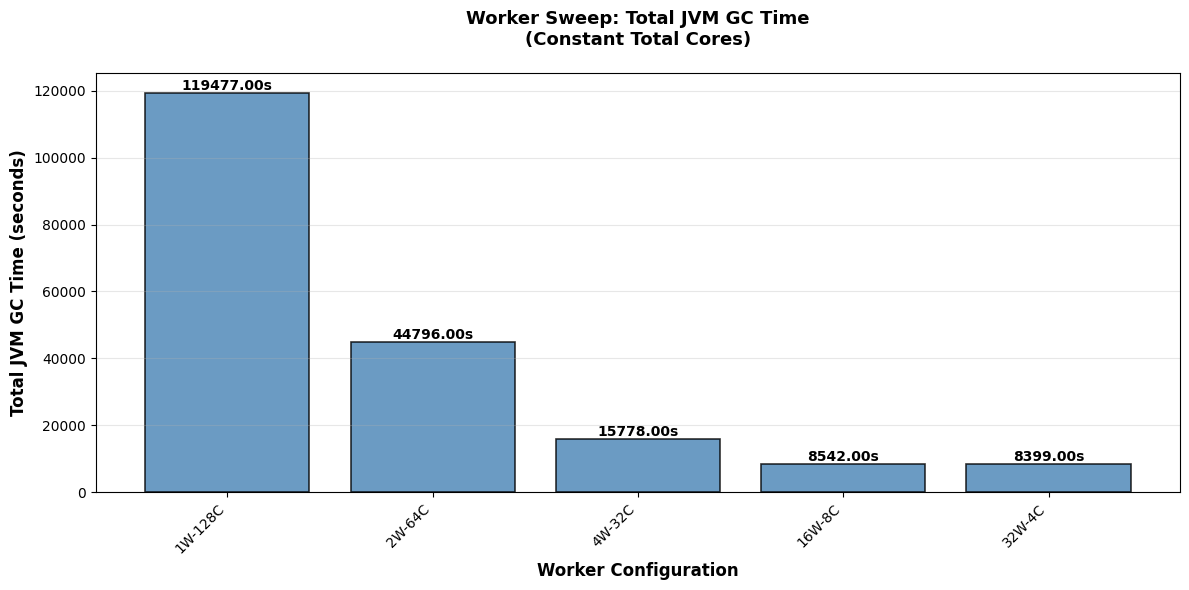

Worker Sweep - Total JVM GC Time Analysis:
Config       Workers    Cores/W    Total Cores  E2E Time        Total GC Time       
--------------------------------------------------------------------------------------------------------------
1W-128C      1          128        128                 268.53s          119477.00s
2W-64C       2          64         128                 161.92s           44796.00s
4W-32C       4          32         128                 126.04s           15778.00s
16W-8C       16         8          128                 132.56s            8542.00s
32W-4C       32         4          128                 135.90s            8399.00s


In [10]:
# Worker Sweep JVM GC Time Analysis
df_worker_gc = df_worker_sweep.copy()

# Create configuration labels
df_worker_gc['config_name'] = (
    df_worker_gc['num_workers'].astype(str) + 'W-' +
    df_worker_gc['cores_per_worker'].astype(str) + 'C'
)

df_worker_gc['total_cores'] = df_worker_gc['num_workers'] * df_worker_gc['cores_per_worker']
df_worker_gc = df_worker_gc.sort_values('num_workers')

# Create bar chart for Total JVM GC Time
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

bars = ax.bar(df_worker_gc['config_name'], df_worker_gc['Total_JVM_GC_Time'], 
              color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.2)

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}s',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Worker Configuration', fontsize=12, fontweight='bold')
ax.set_ylabel('Total JVM GC Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Worker Sweep: Total JVM GC Time\n(Constant Total Cores)', 
             fontsize=13, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print detailed analysis
print("Worker Sweep - Total JVM GC Time Analysis:")
print("=" * 110)
print(f"{'Config':<12} {'Workers':<10} {'Cores/W':<10} {'Total Cores':<12} {'E2E Time':<15} {'Total GC Time':<20}")
print("-" * 110)
for _, row in df_worker_gc.iterrows():
    print(f"{row['config_name']:<12} {row['num_workers']:<10} {row['cores_per_worker']:<10} "
          f"{row['total_cores']:<12} {row['E2E_time']:>13.2f}s {row['Total_JVM_GC_Time']:>18.2f}s")


## 8. Export Processed Data with Derived Metrics

Export all processed data to a new CSV file containing derived total metrics instead of per-stage values.

In [11]:
# Combine all datasets and prepare for export
all_data = []

# Process Strong Scaling data
if not df_strong_scaling.empty:
    df_ss_export = df_strong_scaling.copy()
    df_ss_export['scaling_type'] = 'Strong_Scaling'
    all_data.append(df_ss_export)

# Process Weak Scaling data
if not df_weak_scaling.empty:
    df_ws_export = df_weak_scaling.copy()
    df_ws_export['scaling_type'] = 'Weak_Scaling'
    all_data.append(df_ws_export)

# Process Worker Sweep data
if not df_worker_sweep.empty:
    df_w_export = df_worker_sweep.copy()
    df_w_export['scaling_type'] = 'Worker_Sweep'
    all_data.append(df_w_export)

# Combine all data
df_combined = pd.concat(all_data, ignore_index=True)

# Select columns to keep in the output
# Keep basic config columns
basic_cols = ['scaling_type', 'num_workers', 'cores_per_worker', 'dataset_scale']

# Keep end-to-end metrics
e2e_cols = [col for col in df_combined.columns if col.startswith('E2E_')]

# Keep the derived total metrics we calculated
derived_cols = ['total_stage_time', 'average_stage_throughput', 
                'Total_Executor_Run_Time', 'Total_Executor_CPU_Time', 'Total_JVM_GC_Time']

# Remove per-stage columns (individual stage metrics)
per_stage_cols = [col for col in df_combined.columns if 
                  (col.startswith('stage') and 
                   (col.endswith('_time') or col.endswith('_throughput') or 
                    col.endswith('_executorRunTime') or col.endswith('_executorCpuTime') or 
                    col.endswith('_jvmGCTime')))]

# Select final columns to export
columns_to_export = basic_cols + e2e_cols + derived_cols

# Create the final export dataframe with only the columns we want
df_export = df_combined[columns_to_export].copy()

# Add additional calculated metrics
df_export['total_cores'] = df_export['num_workers'] * df_export['cores_per_worker']
df_export['CPU_Efficiency'] = (df_export['Total_Executor_CPU_Time'] / df_export['Total_Executor_Run_Time']) * 100

# Sort by scaling type and total cores
df_export = df_export.sort_values(['scaling_type', 'total_cores'])

# Define output file path
output_file = os.path.join(LOG_DIR, "processed_metrics_with_totals.csv")

# Export to CSV
df_export.to_csv(output_file, index=False)

print(f"✓ Data exported successfully to: {output_file}")
print(f"✓ Total records: {len(df_export)}")
print(f"✓ Columns exported: {len(df_export.columns)}")
print(f"\nColumns in exported CSV:")
print("-" * 60)
for col in df_export.columns:
    print(f"  - {col}")
    
print(f"\nFirst few rows of exported data:")
print("=" * 120)
print(df_export.head(10).to_string())

✓ Data exported successfully to: /home/intel/ritik/iisc/deas-project/logs-prod/6767P/4-cores-per-worker/processed_metrics_with_totals.csv
✓ Total records: 15
✓ Columns exported: 13

Columns in exported CSV:
------------------------------------------------------------
  - scaling_type
  - num_workers
  - cores_per_worker
  - dataset_scale
  - E2E_time
  - E2E_throughput
  - total_stage_time
  - average_stage_throughput
  - Total_Executor_Run_Time
  - Total_Executor_CPU_Time
  - Total_JVM_GC_Time
  - total_cores
  - CPU_Efficiency

First few rows of exported data:
     scaling_type  num_workers  cores_per_worker  dataset_scale    E2E_time  E2E_throughput  total_stage_time  average_stage_throughput  Total_Executor_Run_Time  Total_Executor_CPU_Time  Total_JVM_GC_Time  total_cores  CPU_Efficiency
4  Strong_Scaling            1                 4         1.0000  270.342629     2933.355364           173.542               4154.672672                 544593.0                 186269.0            